# Model training for satisfaction prediction and recommender sysetem

# Satisfaction Prediction System

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Install xgboost if not already installed
%pip install xgboost
import xgboost as xgb


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: c:\Users\IQRA SHAIKH\OneDrive\Documents\GitHub\Customer_Satisfaction_prediction\venv\Scripts\python.exe -m pip install --upgrade pip


  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Loading dataset from project folder
df = pd.read_csv(r"C:\Users\IQRA SHAIKH\OneDrive\Documents\GitHub\Customer_Satisfaction_prediction\project\processed_customer_satisfaction.csv")
df.head(3)

,Customer Age,Customer Gender,Product Purchased,Ticket Type,Ticket Status,Resolution,Ticket Priority,Ticket Channel,Customer Satisfaction Rating,Response Delay (hrs),Resolution Time (hrs),Age Group
0,32,2,16,4,2,1530,0,3,0.0,19236.260000,0.166667,1
1,42,0,21,4,2,1530,0,0,0.0,17776.760556,0.166667,2
2,48,2,10,4,0,343,2,3,3.0,25259.243889,6.850000,2


In [4]:
# Separating features and target
X = df.drop('Customer Satisfaction Rating', axis=1)
y = df['Customer Satisfaction Rating'].astype(int)

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Defining models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [9]:
# Evaluation metrics
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    r2 = r2_score(y_test, y_pred)

    try:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled), multi_class='ovr')
    except:
        roc_auc = np.nan

    results.append({
        "Model": name,
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4),
        "R² Score": round(r2, 4),
        "ROC AUC": round(roc_auc, 4) if not pd.isnull(roc_auc) else "N/A"
    })

c:\Users\IQRA SHAIKH\OneDrive\Documents\GitHub\Customer_Satisfaction_prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:49:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [10]:
# Results as DataFrame
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\n📊 Model Evaluation Summary:\n")
print(results_df.to_string(index=False))


📊 Model Evaluation Summary:

              Model  Accuracy  Precision  Recall  F1 Score  R² Score  ROC AUC
Logistic Regression    0.7403     0.7431  0.7403    0.7385    0.5819   0.8805
      Decision Tree    0.7285     0.7296  0.7285    0.7288    0.5097   0.6418
            XGBoost    0.7249     0.7260  0.7249    0.7251    0.4734   0.8764
      Random Forest    0.7226     0.7245  0.7226    0.7231    0.4968   0.8777
                KNN    0.7107     0.6836  0.7107    0.6953    0.3695   0.7527


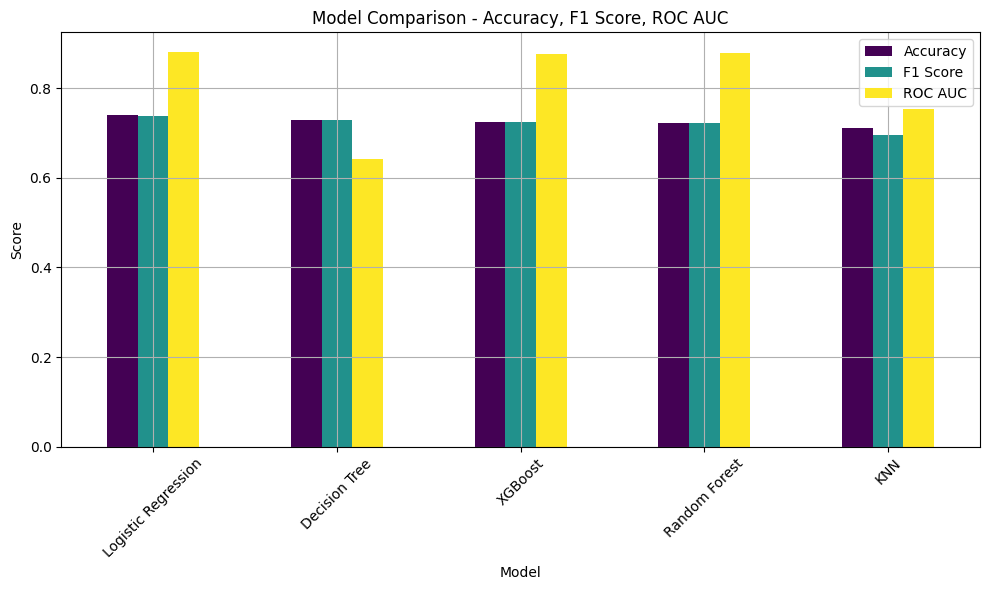

In [13]:
import matplotlib.pyplot as plt

# Plot comparison
results_df.set_index("Model")[["Accuracy", "F1 Score", "ROC AUC"]].plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Model Comparison - Accuracy, F1 Score, ROC AUC")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [12]:
import joblib
from sklearn.linear_model import LogisticRegression

# Training the best model again
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train_scaled, y_train)

# Defining save path
save_path = r"C:\Users\IQRA SHAIKH\OneDrive\Documents\GitHub\Customer_Satisfaction_prediction\models"

# Saving the model, scaler, and feature list
joblib.dump(best_model, f"{save_path}\\logistic_model.pkl")
joblib.dump(scaler, f"{save_path}\\scaler.pkl")
joblib.dump(X.columns.tolist(), f"{save_path}\\features.pkl")

print("✅ Logistic Regression model and components saved in 'models' folder.")


✅ Logistic Regression model and components saved in 'models' folder.


# 🎯 Recommendation System: TF-IDF + KNN

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(df['Ticket Subject'])

KeyError: 'Ticket Subject'